In [2]:
import pandas as pd

dataset = pd.read_csv('./input/Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
dataset.tail()

,Review,Liked
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [6]:
dataset.iloc[0]

Review    Wow... Loved this place.
Liked                            1
Name: 0, dtype: object

In [15]:
pos = 0
neg = 0
for val in dataset['Liked']:
    if val == 0:
        neg+=1
    else:
        pos+=1

print(f'positive: {pos}, negative: {neg}')

positive: 500, negative: 500


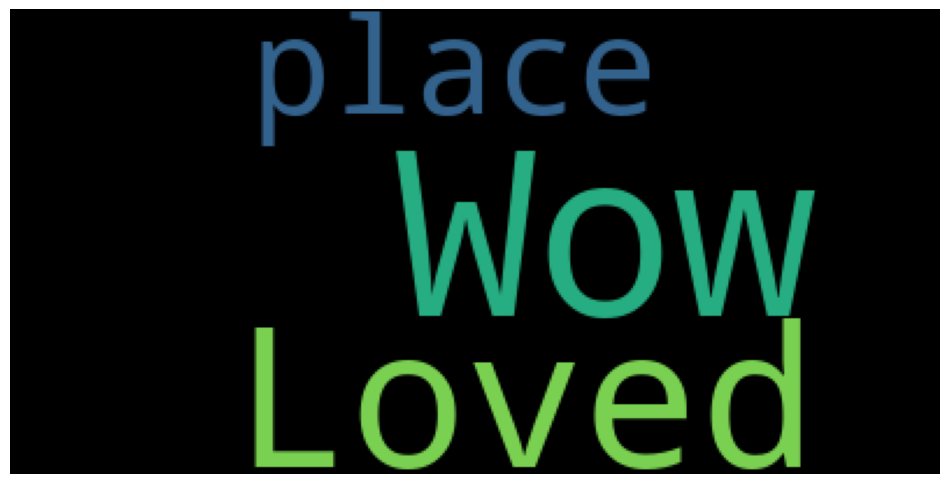

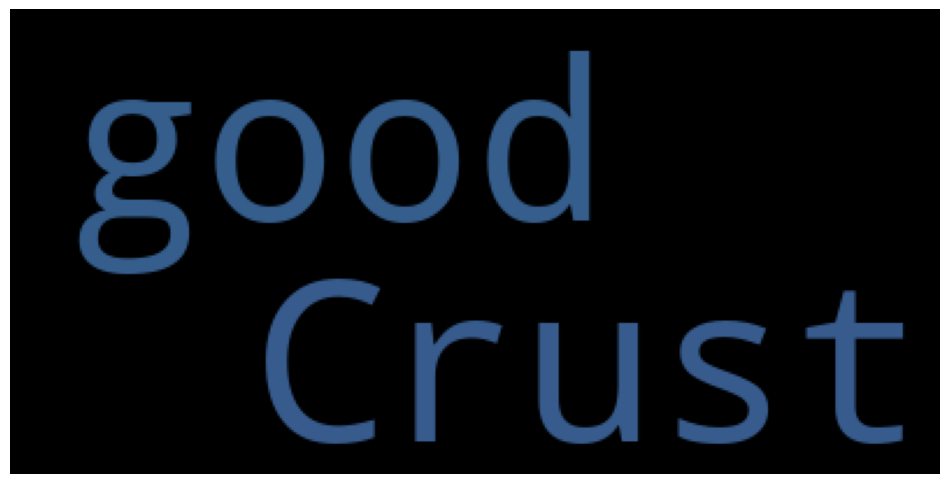

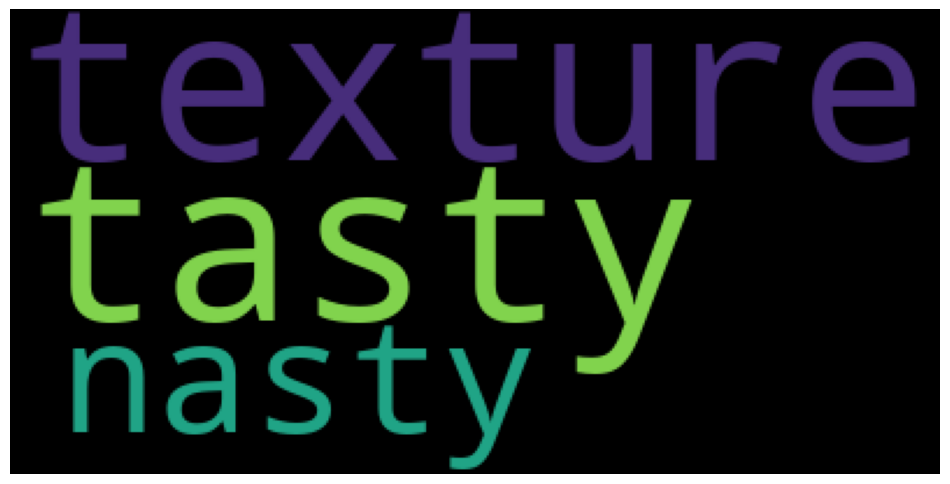

In [39]:
# check some reviews with knowledge learned from the lecture

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# get stop words
stop_words = set(stopwords.words("english"))
# list of negative words
negative_words = {'no', 'not', "don't", "doesn't", "didn't", "isn't", "aren't", "won't"}
# exclude the negative words from stop words
stopwords = stop_words - negative_words


for i in range(3):
    text = dataset['Review'][i]
    tokenized_word = word_tokenize(text)

    tokens_without_stopwords = [word for word in tokenized_word
                                if not word in stopwords]
    
    wordcloud = WordCloud().generate(text)

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)

    plt.axis("off")
    plt.show()

In [14]:
# Version of using Naive-Bayse classifier from scratch


# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np

# fix a seed to make the constant result
SEED = 215

class NaiveBayesClassifier:
    def __init__(self, laplace=1):
        self.laplace = laplace

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Initialize probabilities
        self._log_prior = np.zeros(n_classes)
        self._word_count = np.zeros((n_classes, n_features))
        self._word_sum = np.zeros(n_classes)

        for c in self._classes:
            X_c = X[y == c]
            self._word_count[c, :] = X_c.sum(axis=0)
            self._word_sum[c] = X_c.sum()
            self._log_prior[c] = np.log(X_c.shape[0] / n_samples)

        self._word_prob = np.log(self._word_count + self.laplace)
        - np.log(self._word_sum[:, np.newaxis]
                 + n_features * self.laplace)

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self._classes):
            posterior = self._log_prior[idx]
            posterior += (self._word_prob[idx, :] * x).sum()
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]



# Prepare stop words from NLTK library, excluding negative words
# as they may carry sentiment meaning
stop_words = set(stopwords.words("english"))
negative_words = {'no', 'not', "don't", "doesn't", "didn't", "isn't",
                  "aren't", "won't"}
stop_words = stop_words - negative_words

# Data preprocessing: Tokenize, remove stop words, stem, and rejoin
# to form the final corpus
corpus = []
for i in range(0, len(dataset)):
    tokens = word_tokenize(dataset['Review'][i].lower())
    ps = PorterStemmer()
    review = [ps.stem(word) for word in tokens if word
              not in stop_words and word.isalpha()]
    corpus.append(' '.join(review))

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features = 900)
X = tfidf.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=SEED)

# Training using Multinomial Naive Bayes classifier,
# which includes log-likelihood and Laplace smoothing by default
classifier = NaiveBayesClassifier()
classifier.fit(X_train, y_train)

# Prediction on the test dataset
y_test_pred = classifier.predict(X_test)

# Evaluation of the model using confusion matrix
# and various performance metrics
cm_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Display the performance metrics
print("Test Results - Performance Metrics:")
print(f"Confusion Matrix:\n{cm_test}")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")


Test Results - Performance Metrics:
Confusion Matrix:
[[76 25]
 [18 81]]
Accuracy: 0.79
Precision: 0.76
Recall: 0.82
F1 Score: 0.79


In [16]:
# Version of using Naive-Bayse classifier from library


# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Prepare stop words from NLTK library, excluding negative words as they may carry sentiment meaning
stop_words = set(stopwords.words("english"))
negative_words = {'no', 'not', "don't", "doesn't", "didn't", "isn't", "aren't", "won't"}
stop_words = stop_words - negative_words

# Data preprocessing: Tokenize, remove stop words, stem, and rejoin to form the final corpus
corpus = []
for i in range(0, len(dataset)):
    tokens = word_tokenize(dataset['Review'][i].lower())
    ps = PorterStemmer()
    review = [ps.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    corpus.append(' '.join(review))

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features = 900)
X = tfidf.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=215)

# Training using Multinomial Naive Bayes classifier, which includes log-likelihood and Laplace smoothing by default
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Prediction on the test dataset
y_test_pred = classifier.predict(X_test)

# Evaluation of the model using confusion matrix and various performance metrics
cm_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Display the performance metrics
print("Test Results - Performance Metrics:")
print(f"Confusion Matrix:\n{cm_test}")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")


Test Results - Performance Metrics:
Confusion Matrix:
[[76 25]
 [18 81]]
Accuracy: 0.79
Precision: 0.76
Recall: 0.82
F1 Score: 0.79
